In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Flatten, Conv3D, MaxPooling3D, BatchNormalization
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import os
hgg_train_dir = 'Downloads/archive/seg_images_hgg/train_hgg'  
lgg_train_dir = 'Downloads/archive/seg_images_lgg/train_lgg'
hgg_val_dir = 'Downloads/archive/seg_images_hgg/val_hgg'
lgg_val_dir = 'Downloads/archive/seg_images_lgg/val_lgg'


def load_npy_files_and_labels(directory, label):
    data = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):  
    
            file_path = os.path.join(directory, filename)
            
            try:
                img_data = np.load(file_path)
                data.append(img_data)
                labels.append(label)
            except PermissionError:
                print(f"Permission error with file: {file_path}")
    
    return np.array(data), np.array(labels)


hgg_train_data, hgg_train_labels = load_npy_files_and_labels(hgg_train_dir, 1)  # Label 1 for HGG
lgg_train_data, lgg_train_labels = load_npy_files_and_labels(lgg_train_dir, 0)  # Label 0 for LGG

print(hgg_train_data.shape)
print(lgg_train_data.shape)


(1000, 128, 128, 64)
(1000, 128, 128, 64)


In [ ]:
hgg_val_data, hgg_val_labels = load_npy_files_and_labels(hgg_val_dir, 1)  # Label 1 for HGG
lgg_val_data, lgg_val_labels = load_npy_files_and_labels(lgg_val_dir, 0)  # Label 0 for LGG


train_data = np.concatenate((hgg_train_data, lgg_train_data), axis=0)
train_labels = np.concatenate((hgg_train_labels, lgg_train_labels), axis=0)

val_data = np.concatenate((hgg_val_data, lgg_val_data), axis=0)
val_labels = np.concatenate((hgg_val_labels, lgg_val_labels), axis=0)

print(f'Training data shape: {train_data.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print("Unique labels and counts in combined validation labels:", np.unique(val_labels, return_counts=True))

Training data shape: (2000, 128, 128, 64)
Training labels shape: (2000,)
Validation data shape: (100, 128, 128, 64)
Validation labels shape: (100,)
Unique labels and counts in combined validation labels: (array([0, 1]), array([20, 80], dtype=int64))


In [4]:
print("HGG Labels Count:", len(hgg_val_labels))
print("LGG Labels Count:", len(lgg_val_labels))
print("Combined Validation Labels Count:", len(hgg_val_labels) + len(lgg_val_labels))

HGG Labels Count: 80
LGG Labels Count: 20
Combined Validation Labels Count: 100


In [ ]:

print(f"HGG train labels shape: {hgg_train_labels.shape}")
print(f"LGG train labels shape: {lgg_train_labels.shape}")


print(f"Unique values in HGG labels: {np.unique(hgg_train_labels)}")  # It should return [1]
print(f"Unique values in LGG labels: {np.unique(lgg_train_labels)}")  # It should return [0]

print(f"First few HGG labels: {hgg_train_labels[:10]}")
print(f"First few LGG labels: {lgg_train_labels[:10]}")

HGG train labels shape: (1000,)
LGG train labels shape: (1000,)
Unique values in HGG labels: [1]
Unique values in LGG labels: [0]
First few HGG labels: [1 1 1 1 1 1 1 1 1 1]
First few LGG labels: [0 0 0 0 0 0 0 0 0 0]


In [ ]:

print(f"Combined training data shape: {train_data.shape}")
print(f"Combined training labels shape: {train_labels.shape}")
print(f"Combined validation data shape: {val_data.shape}")
print(f"Combined validation labels shape: {val_labels.shape}")

print(f"Unique values in training labels: {np.unique(train_labels)}")  # It should return [0, 1]
print(f"Unique values in validation labels: {np.unique(val_labels)}")  # It Should return [0, 1]

print(f"First few training labels: {train_labels[:10]}")
print(f"First few validation labels: {val_labels[:10]}")

Combined training data shape: (2000, 128, 128, 64)
Combined training labels shape: (2000,)
Combined validation data shape: (100, 128, 128, 64)
Combined validation labels shape: (100,)
Unique values in training labels: [0 1]
Unique values in validation labels: [0 1]
First few training labels: [1 1 1 1 1 1 1 1 1 1]
First few validation labels: [1 1 1 1 1 1 1 1 1 1]


In [7]:
activation = 'relu'

In [8]:
feature_extractor = Sequential()
feature_extractor.add(Conv3D(32, 3, activation = activation, padding = 'same', input_shape = (128, 128,64, 1)))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling3D())

feature_extractor.add(Conv3D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling3D())

feature_extractor.add(Conv3D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling3D())

feature_extractor.add(Flatten())


In [ ]:
def train_preprocessing(image, label):
    # Converting the image to float32
    image = tf.cast(image, tf.float32)
    # Adding channel dimension without normalization
    image = tf.expand_dims(image, axis=-1)  # Shape: (128, 128, 64, 1)
    return image, label

def validation_preprocessing(image, label):
    # Converting the image to float32
    image = tf.cast(image, tf.float32)
    # Adding channel dimension without normalization
    image = tf.expand_dims(image, axis=-1)  # Shape: (128, 128, 64, 1)
    return image, label


In [ ]:
import tensorflow as tf

train_loader = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
validation_loader = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

batch_size = 2

# Creating train and validation datasets
train_dataset = (
    train_loader
    .shuffle(len(train_data))  # Shuffle operation
    .map(train_preprocessing)  # Preprocessing
    .batch(batch_size)         # Creating batches
    .prefetch(2)  # Prefetching for performance
)

validation_dataset = (
    validation_loader
    .map(validation_preprocessing)  
    .batch(batch_size)              
    .prefetch(2)     
)


In [ ]:
def extract_features_in_batches(dataset, feature_extractor):
    features = []
    labels = []
    
    # Iterating through batches
    for batch_data, batch_labels in dataset:
        # Extracting features using CNN
        batch_features = feature_extractor.predict(batch_data)
        
        # Appending the features and labels
        features.append(batch_features)
        labels.append(batch_labels)
        
    # Concatenating the results
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return features, labels


In [ ]:
# Extracting features for training and validation sets
X_train_features, y_train_labels = extract_features_in_batches(train_dataset, feature_extractor)
X_val_features, y_val_labels = extract_features_in_batches(validation_dataset, feature_extractor)



1/1 [==============================] - 0s 16ms/step


In [ ]:
# Training Random Forest on extracted features acc=87
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_features, y_train_labels)

RandomForestClassifier()

In [ ]:
# Prediction using Random Forest
rf_predictions = rf_model.predict(X_val_features)

In [ ]:
# Evaluating Random Forest
accuracy = accuracy_score(y_val_labels, rf_predictions)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

Random Forest Accuracy: 86.00%


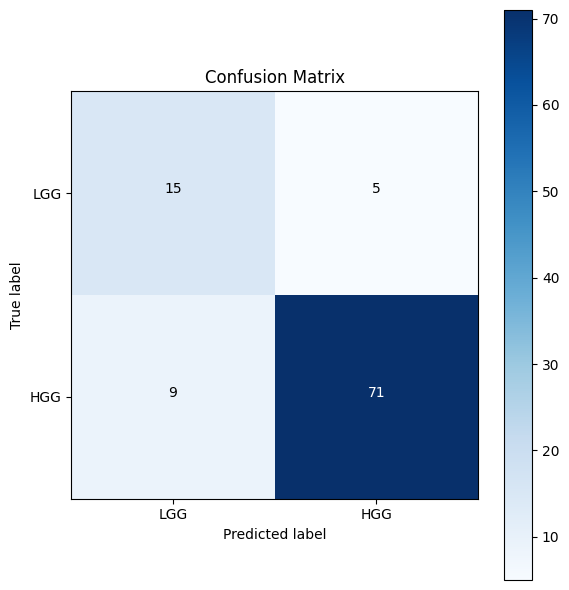

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_val_labels, rf_predictions)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding labels and ticks
classes = ['LGG', 'HGG']  # Assuming 0 = LGG and 1 = HGG
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Annotating the matrix with numbers
thresh = cm.max() / 2.0
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Labels and axis
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



In [53]:
report = classification_report(y_val_labels, rf_predictions)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
           1       0.93      0.89      0.91        80

    accuracy                           0.86       100
   macro avg       0.78      0.82      0.80       100
weighted avg       0.87      0.86      0.86       100



In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_val_labels, rf_predictions)

print('Confusion Matrix:\n', matrix)


Confusion Matrix:
 [[15  5]
 [ 9 71]]


In [33]:
print("Unique labels and counts in y_val_labels:", np.unique(y_val_labels, return_counts=True))


Unique labels and counts in y_val_labels: (array([0, 1]), array([20, 80], dtype=int64))


In [34]:
save_dir = 'Downloads/archive/model_cnn/cnn_rf'

In [35]:
# Save the features in the specified directory
np.save(os.path.join(save_dir, 'X_train_features.npy'), X_train_features)
np.save(os.path.join(save_dir, 'X_val_features.npy'), X_val_features)

# Save the labels as well for future use
np.save(os.path.join(save_dir, 'y_train_labels.npy'), train_labels)
np.save(os.path.join(save_dir, 'y_val_labels.npy'), val_labels)

print(f"Features and labels saved in {save_dir}")

Features and labels saved in Downloads/archive/model_cnn/cnn_rf


In [ ]:

# Defining the directory path
load_dir = 'Downloads/archive/model_cnn/cnn_rf'

# Loading the features and labels
X_train_features = np.load(os.path.join(load_dir, 'X_train_features.npy'))
X_val_features = np.load(os.path.join(load_dir, 'X_val_features.npy'))
y_train_labels = np.load(os.path.join(load_dir, 'y_train_labels.npy'))
y_val_labels = np.load(os.path.join(load_dir, 'y_val_labels.npy'))

print("Data loaded successfully:")



Data loaded successfully:
